In [7]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img,array_to_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

from keras import backend as K
from keras.utils import plot_model
K.set_image_dim_ordering('th')
import os
import matplotlib.pyplot as plt
os.chdir("/home/ubuntu/data/")

from IPython.display import Image, display, clear_output
import datetime

In [8]:
#reshape images
datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

def testIDGen():
    img = load_img('train/Benign/ISIC_0009871.jpg')  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

    # the .flow() command below generates batches of randomly transformed images
    # and saves the results to the `preview/` directory
    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir='.', save_prefix='cat', save_format='jpeg'):
        i += 1
        if i >= 5:
            break  # otherwise the generator would loop indefinitely
    ##############################

In [9]:
# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'train'
validation_data_dir = 'validation'
test_dir = 'test'
nb_train_samples = 800
nb_validation_samples = 370
epochs = 20
batch_size = 10


def save_bottlebeck_features():
    #datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save('bottleneck_features_train',
        bottleneck_features_train)

    print("done train")
    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save('bottleneck_features_validation',
            bottleneck_features_validation)
    print("done valid")
    return


save_bottlebeck_features()

/usr/local/lib/python3.5/dist-packages/keras/applications/vgg16.py:182: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


Found 841 images belonging to 2 classes.
done train
Found 373 images belonging to 2 classes.
done valid


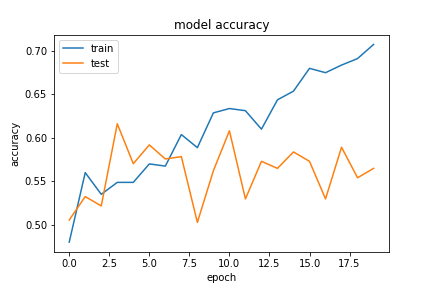

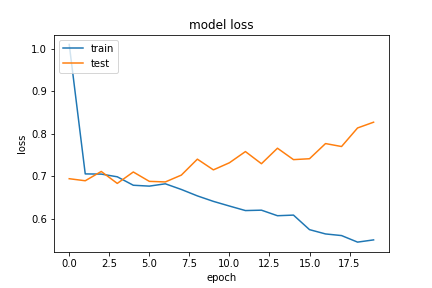

ended fitting and saving


In [10]:
def plot_nicely(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    time_now = datetime.datetime.now()
    time_string = str(time_now.hour) + str(time_now.minute)
    fileName1 = "1_lastLayer_" + time_string + "_1.png"
    fileName2 = "1_lastLayer_" + time_string + "_2.png"
    
    plt.savefig(fileName1)
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(fileName2)
    plt.show()
    
    clear_output(True)
    display(Image(filename=fileName1))
    display(Image(filename=fileName2))
    return

def train_top_model():
    train_data = np.load('bottleneck_features_train.npy')
    train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

    validation_data = np.load('bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

    history = None
    epoch_plot_step = 5
    for a in range(epochs // epoch_plot_step):
        if a == 0:
            history = model.fit(train_data, train_labels,
                      epochs=epoch_plot_step,
                      batch_size=batch_size,
                      validation_data=(validation_data, validation_labels))
        else:
            newHistory = model.fit(train_data, train_labels,
                      epochs=epoch_plot_step,
                      batch_size=batch_size,
                      validation_data=(validation_data, validation_labels))
            for b in history.history:
                history.history[b] += newHistory.history[b]
        plot_nicely(history)
    
    model.save_weights(top_model_weights_path)
    
    #SVG(model_to_dot(model).create(prog='dot', format='svg'))
    #plot_model(model, to_file='model.png')
    print("ended fitting and saving")
    return history


history = train_top_model()

In [ ]:
def predict_image_class(file):
    model = applications.VGG16(include_top=False, weights='imagenet')
    x = load_img(file, target_size=(img_width,img_height))
    x = img_to_array(x)
    x = np.expand_dims(x, axis=0)
    array = model.predict(x)
    model = Sequential()
    model.add(Flatten(input_shape=array.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.load_weights(top_model_weights_path)
    class_predicted = model.predict_classes(array)
    if class_predicted==1:
        print("malignant")
    else:
        print("benign")
        
predict_image_class(test_dir + "/catTest.jpg")
predict_image_class(test_dir + "/dogTest.jpg")